In [14]:
# jupyter lab에서 자동완성이 않될때 사용하는 코드
%config Completer.use_jedi = False

# 객체 탐지(Object Detection)

## 의료용 마스크 탐지 모델 구축

데이터: 캐글에 있는 데이터셋(https://www.kaggle.com/andrewmvd/face-mask-detection)

classes: mask_weared_incorrect, with_mask, without_mask

### 데이터 확인하기

In [15]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from bs4 import BeautifulSoup
import torch

In [16]:
img_list = sorted(glob.glob('data/images/*'))
annot_list = sorted(glob.glob('data/annotations/*'))

len(img_list), len(annot_list)

(683, 683)

In [17]:
# 리스트 확인하기
print(img_list[:10])

print(annot_list[:10])

['data/images\\maksssksksss0.png', 'data/images\\maksssksksss1.png', 'data/images\\maksssksksss10.png', 'data/images\\maksssksksss100.png', 'data/images\\maksssksksss101.png', 'data/images\\maksssksksss103.png', 'data/images\\maksssksksss105.png', 'data/images\\maksssksksss106.png', 'data/images\\maksssksksss107.png', 'data/images\\maksssksksss108.png']
['data/annotations\\maksssksksss0.xml', 'data/annotations\\maksssksksss1.xml', 'data/annotations\\maksssksksss10.xml', 'data/annotations\\maksssksksss100.xml', 'data/annotations\\maksssksksss101.xml', 'data/annotations\\maksssksksss103.xml', 'data/annotations\\maksssksksss105.xml', 'data/annotations\\maksssksksss106.xml', 'data/annotations\\maksssksksss107.xml', 'data/annotations\\maksssksksss108.xml']


### Get labels

In [18]:
def generate_box(obj):
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    name = obj.find('name').text
    if name == "with_mask":
        return 1
    elif name == "mask_weared_incorrect":
        return 2
    return 0    # without_mask

def generate_target(file):
    with open(file) as f:
        soup = BeautifulSoup(f.read(), 'html.parser')
        objects = soup.find_all('object')
        num_objs = len(objects)

        boxes, labels = [], []
        for obj in objects:
            boxes.append(generate_box(obj))
            labels.append(generate_label(obj))
            
        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        labels = torch.as_tensor(labels, dtype=torch.int64) 

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        return target

def plot_image(img_path, annotation):
    
    img = mpimg.imread(img_path)
    
    fig,ax = plt.subplots(1)
    ax.imshow(img)

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        elif annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
        else:
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

{'boxes': tensor([[273.,  87., 300., 116.],
        [344.,  60., 366.,  88.],
        [246.,  50., 271.,  82.],
        [146., 104., 169., 126.],
        [163.,  80., 184., 103.],
        [  1.,  69.,  33., 130.],
        [124.,  86., 142., 104.],
        [ 98.,  78., 119.,  96.],
        [ 31.,  78.,  46.,  93.],
        [ 72.,  78.,  88.,  91.],
        [ 58.,  72.,  66.,  82.],
        [200.,  70., 211.,  82.]]), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])}


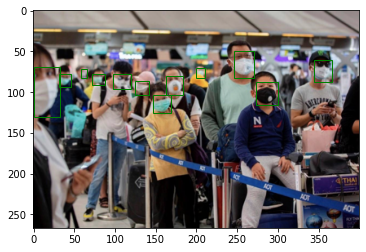

In [19]:
# function test
idx = 103
img_path = img_list[idx]
label_path = annot_list[idx]

bbox = generate_target(label_path)
print(bbox)

plot_image(img_path, bbox)

## 데이터 전처리

## Albmentations

In [20]:
def plot_image_from_output(img, annotation):
    
    img = img.permute(1,2,0)
    
    fig,ax = plt.subplots(1)
    ax.imshow(img)

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        elif annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
        else:
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

In [21]:
from PIL import Image
import cv2
import numpy as np
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations
import albumentations.pytorch
from matplotlib import pyplot as plt
import os
import random


class AlbumentationsDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        
        if 'test' in self.path:
            label_path = os.path.join('data/test_annotations/', file_label)
        else:
            label_path = os.path.join('data/annotations/', file_label)
            
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        target = generate_target(label_path)
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        return image, target
        

In [76]:
albumentations_transform = albumentations.Compose([
    albumentations.Resize(300, 300), 
    albumentations.RandomCrop(224, 224),
    albumentations.ColorJitter(p=1), 
    albumentations.HorizontalFlip(p=1), 
    albumentations.pytorch.transforms.ToTensor()
])

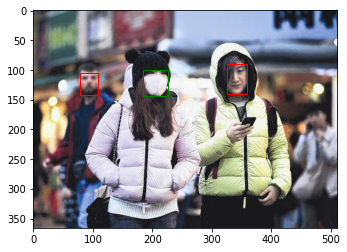

In [77]:
# 원본 이미지
bbox = generate_target(annot_list[0])
plot_image(img_list[0], bbox)

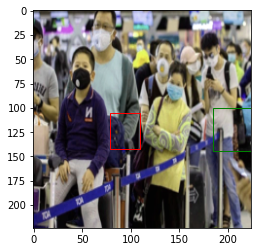

In [79]:
albumentation_dataset = AlbumentationsDataset(
    path = 'data/images/',
    transform = albumentations_transform
)
img, annot = albumentation_dataset[0]
plot_image_from_output(img, annot)

### 확률 기반 Augmentation 조합

OneOf() 함수

In [25]:
albumentations_transform_oneof = albumentations.Compose([
    albumentations.Resize(300, 300),
    albumentations.RandomCrop(224, 224),
    albumentations.OneOf([
        albumentations.HorizontalFlip(p=1),
        albumentations.RandomRotate90(p=1),
        albumentations.VerticalFlip(p=1)
    ], p=1),
    albumentations.OneOf([
        albumentations.MotionBlur(p=1),
        albumentations.OpticalDistortion(p=1),
        albumentations.GaussNoise(p=1)
    ], p=1),
    albumentations.pytorch.ToTensor()
])

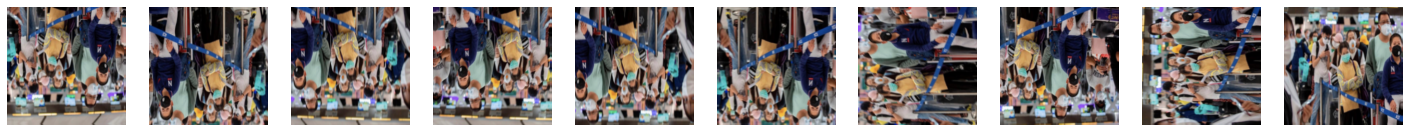

In [26]:
albumentation_dataset_oneof = AlbumentationsDataset(path = 'data/images/', transform = albumentations_transform_oneof)

num_samples = 10
fig, ax = plt.subplots(1, num_samples, figsize=(25, 5))
for i in range(num_samples):
    ax[i].imshow(transforms.ToPILImage()(albumentation_dataset_oneof[0][0]))
    ax[i].axis('off')

## Bounding box Augmentation

In [80]:
class BboxAugmentationDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)
        
        if 'test' in self.path:
            label_path = os.path.join('data/test_annotations/', file_label)
        else:
            label_path = os.path.join('data/annotations/', file_label)
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        target = generate_target(label_path)
        
        if self.transform:
            transformed = self.transform(image = image, bboxes = target['boxes'], labels = target['labels'])
            image = transformed['image']
            target = {
                'boxes': transformed['bboxes'],
                'labels': transformed['labels']
            }
            
        return image, target

In [85]:
import albumentations as A

bbox_transform = albumentations.Compose(
    [A.HorizontalFlip(p=1),
     A.Rotate(p=1),
     A.OneOf([
         A.ChannelShuffle(p=1),
         A.RGBShift(p=1)
     ], p=1),
     A.OneOf([
        A.MotionBlur(p=1),
        A.GaussNoise(p=1)
    ], p=1),
     A.pytorch.transforms.ToTensor()],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']),
)

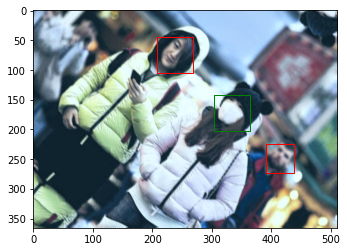

In [107]:
bbox_transform_dataset = BboxAugmentationDataset(
    path = 'data/images/',
    transform = bbox_transform
)

img, annot = bbox_transform_dataset[0]
plot_image_from_output(img, annot)

## 데이터 분리

train : validation : test = 6 : 2 : 2

513 : 170 : 170

In [12]:
import random

random.seed(1234)

In [39]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from bs4 import BeautifulSoup
from PIL import Image
import cv2
import numpy as np
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
from matplotlib import pyplot as plt
import os
import albumentations

def generate_box(obj):
    
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):

    if obj.find('name').text == "with_mask":

        return 1

    elif obj.find('name').text == "mask_weared_incorrect":

        return 2

    return 0

def generate_target(file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        labels = torch.as_tensor(labels, dtype=torch.int64) 
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target

def plot_image_from_output(img, annotation):
    
    img = img.cpu().permute(1,2,0)
    
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 1 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

In [40]:
class MaskDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)
        
        label_path = os.path.join("data/annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        target = generate_target(label_path)
        
        if self.transform:
            img = self.transform(img)
#             img, transform_target = self.transform(np.array(img), np.array(target['boxes']))
#             target['boxes'] = torch.as_tensor(transform_target)
        else:
            to_tensor = torchvision.transforms.ToTensor()
            img = to_tensor(img)

        return img, target

In [41]:
from torch.utils.data.dataset import random_split

In [63]:
base_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
dataset = MaskDataset(path='./data/images/', transform=base_transform)

trainset, testset = random_split(dataset, [683, 170])

In [64]:
dataset[1]

(tensor([[[0.5373, 0.5412, 0.5412,  ..., 0.8941, 0.9059, 0.9098],
          [0.5451, 0.5490, 0.5490,  ..., 0.8980, 0.9098, 0.9098],
          [0.5490, 0.5529, 0.5490,  ..., 0.9020, 0.9098, 0.9176],
          ...,
          [0.1961, 0.1804, 0.1529,  ..., 0.1373, 0.1373, 0.1333],
          [0.2000, 0.1804, 0.1529,  ..., 0.1373, 0.1373, 0.1373],
          [0.2000, 0.1804, 0.1529,  ..., 0.1373, 0.1373, 0.1373]],
 
         [[0.5333, 0.5412, 0.5373,  ..., 0.8902, 0.9059, 0.9137],
          [0.5451, 0.5451, 0.5490,  ..., 0.8941, 0.9059, 0.9137],
          [0.5490, 0.5490, 0.5451,  ..., 0.8980, 0.9098, 0.9216],
          ...,
          [0.1922, 0.1725, 0.1451,  ..., 0.1333, 0.1333, 0.1333],
          [0.1961, 0.1765, 0.1490,  ..., 0.1373, 0.1373, 0.1373],
          [0.1922, 0.1765, 0.1490,  ..., 0.1373, 0.1373, 0.1373]],
 
         [[0.5529, 0.5608, 0.5608,  ..., 0.8706, 0.8863, 0.8941],
          [0.5647, 0.5647, 0.5686,  ..., 0.8745, 0.8863, 0.8941],
          [0.5686, 0.5686, 0.5647,  ...,

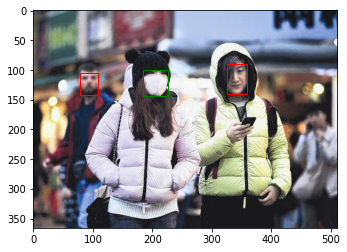

In [65]:
img, annot = dataset[0]
plot_image_from_output(img, annot)

In [71]:
batch_size = 16

def collate_fn(batch):
    return tuple(zip(*batch))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, collate_fn=collate_fn)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, collate_fn=collate_fn)

In [72]:
import torchvision
import torch

In [73]:
# Load RetinaNet model
retina = torchvision.models.detection.retinanet_resnet50_fpn(num_classes = 3, pretrained=False, pretrained_backbone = True)
# retina = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=False, progress=True, num_classes=3, pretrained_backbone=True)

In [75]:
from tqdm import tqdm

In [79]:
# CPU에서는 메모리 부족으로 테스트 불가!
num_epochs = 0

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

retina.to(device)
    
# parameters
params = [p for p in retina.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

len_trainloader = len(trainloader)

for epoch in range(num_epochs):
    start = time.time()
    retina.train()

    i = 0    
    epoch_loss = 0
    for images, targets in trainloader:

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = retina(images, targets) 

        losses = sum(loss for loss in loss_dict.values()) 

        i += 1

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        epoch_loss += losses 
    print(epoch_loss, f'time: {time.time() - start}')

KeyboardInterrupt: 